### 1. Project Overview

##### Problem statement
    Smallholder wheat farmers need a tool to diagnose pests and diseases in wheat crops to prevent yield loss.
##### Goal
    Develop an image classification model for diagnosing wheat pests and diseases, which will be deployable on a web platform for smallholder farmers.
##### Data Source
    The dataset is sourced from https://www.kaggle.com/datasets/kushagra3204/wheat-plant-diseases
##### Pests and Disease Classes
- **Pests**: Aphid
- **Diseases**: Yellow Rust, Mildew, Fusarium Head Blight
- **Healthy**: A class representing healthy crops without pests or diseases.

## Wheat Plant Disease Dataset Setup

In [1]:
#First, we'll import all the necessary libraries to aid in this task
import os
import random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

from imblearn.over_sampling import SMOTE

from skimage.feature import graycomatrix, graycoprops

from sklearn.preprocessing import StandardScaler

from scipy import stats

import logging
import warnings


### Initial Setup and Data Download

In [2]:
# Then, we'll suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [3]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Then we import the required Kaggle library to download our dataset.
import kagglehub
kushagra3204_wheat_plant_diseases_path = kagglehub.dataset_download('kushagra3204/wheat-plant-diseases')

print('Data source import complete.')


Data source import complete.


### Directory Structure Setup
Now we'll set up our directory paths to access the train, test, and validation data. This dataset follows the standard machine learning directory structure with three main splits:
- Training data: Used to train the model
- Test data: Used for final model evaluation
- Validation data: Used during training to tune hyperparameters

In [6]:
# Set up base path and separate paths for train, test, and validation data
base_path = kushagra3204_wheat_plant_diseases_path
train_path = os.path.join(base_path, 'data', 'train')
test_path = os.path.join(base_path, 'data', 'test')
valid_path = os.path.join(base_path, 'data', 'valid')

In [7]:
# Verify the contents of each directory
print("Training data contents:")
print(os.listdir(train_path))

print("\nTest data contents:")
print(os.listdir(test_path))

print("\nValidation data contents:")
print(os.listdir(valid_path))

Training data contents:
['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']

Test data contents:
['aphid_test', 'black_rust_test', 'blast_test', 'brown_rust_test', 'common_root_rot_test', 'fusarium_head_blight_test', 'healthy_test', 'leaf_blight_test', 'mildew_test', 'mite_test', 'septoria_test', 'smut_test', 'stem_fly_test', 'tan_spot_test', 'yellow_rust_test']

Validation data contents:
['aphid_valid', 'black_rust_valid', 'blast_test_valid', 'brown_rust_valid', 'common_root_rot_valid', 'fusarium_head_blight_valid', 'healthy_valid', 'leaf_blight_valid', 'mildew_valid', 'mite_valid', 'septoria_valid', 'smut_valid', 'stem_fly_valid', 'tan_spot_valid', 'yellow_rust_valid']


### Class Selection for Wheat Plant Classification

### Selected Classes
We'll focus on the following classes as per requirements:
- **Pest (1)**: Aphid
- **Diseases (3)**:
  - Yellow Rust
  - Fusarium Head Blight
  - Mildew
- **Control**: Healthy

#### Class Mapping Implementation

In [8]:
# Create a dictionary to map classes across train, validation, and test sets
class_mappings = {
    'train': ['Aphid', 'Yellow Rust', 'Fusarium Head Blight', 'Mildew', 'Healthy'],
    'valid': ['aphid_valid', 'yellow_rust_valid', 'fusarium_head_blight_valid', 'mildew_valid', 'healthy_valid'],
    'test': ['aphid_test', 'yellow_rust_test', 'fusarium_head_blight_test', 'mildew_test', 'healthy_test']
}

In [9]:
#class verification
print("Checking if all required classes exist:")

# Training set check
train_classes = os.listdir(train_path)
print("\nTraining classes found:", [cls for cls in class_mappings['train'] if cls in train_classes])

# Test set check
test_classes = os.listdir(test_path)
print("\nTest classes found:", [cls for cls in class_mappings['test'] if cls in test_classes])

# Validation set check
valid_classes = os.listdir(valid_path)
print("\nValidation classes found:", [cls for cls in class_mappings['valid'] if cls in valid_classes])

Checking if all required classes exist:

Training classes found: ['Aphid', 'Yellow Rust', 'Fusarium Head Blight', 'Mildew', 'Healthy']

Test classes found: ['aphid_test', 'yellow_rust_test', 'fusarium_head_blight_test', 'mildew_test', 'healthy_test']

Validation classes found: ['aphid_valid', 'yellow_rust_valid', 'fusarium_head_blight_valid', 'mildew_valid', 'healthy_valid']


## Exploratory Data Analysis (EDA) of Wheat Disease Dataset


### **1.** Display Sample Images from Each Class and Set

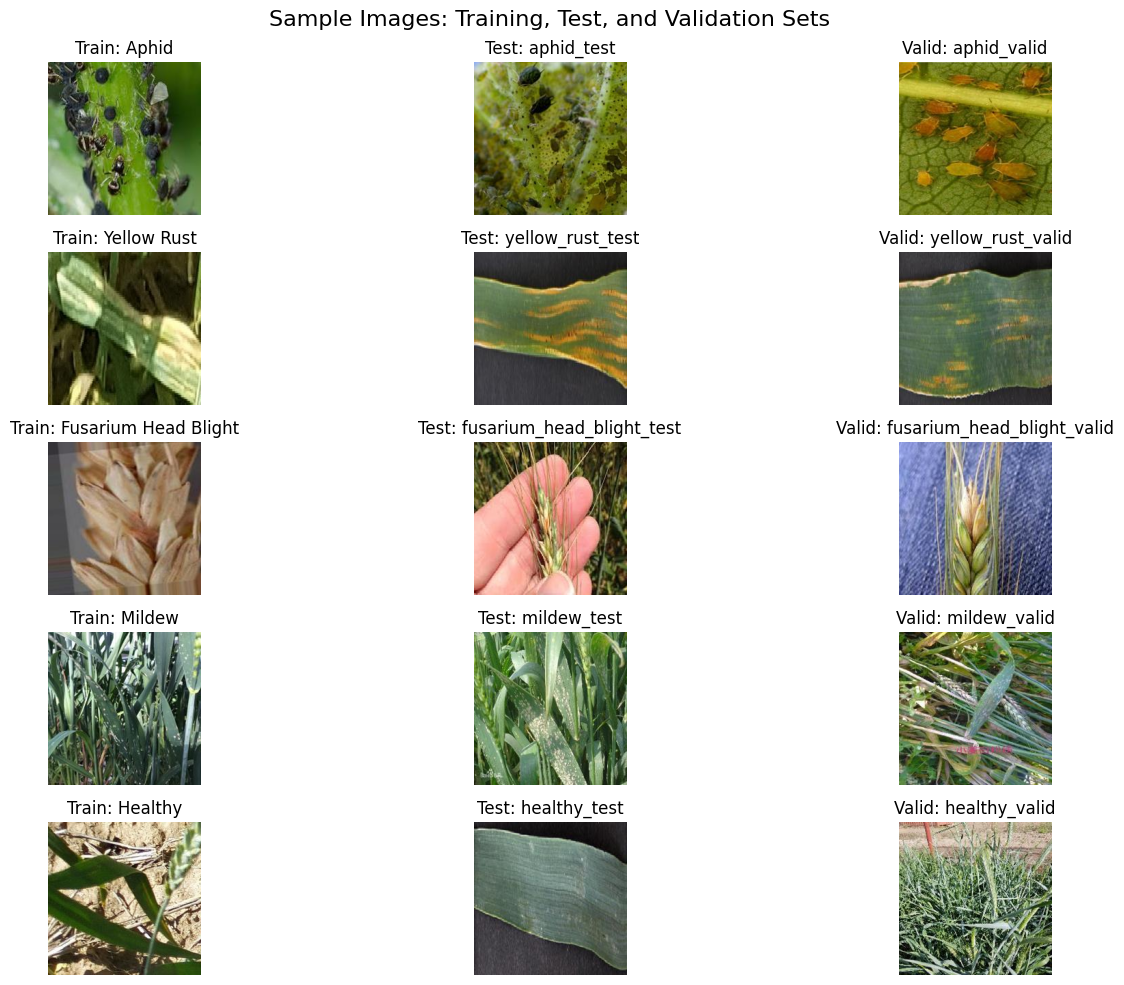

In [10]:
plt.figure(figsize=(15, 10))
plt.suptitle('Sample Images: Training, Test, and Validation Sets', fontsize=16)

# Counter for subplot positions
plot_idx = 1

# Loop through each class
for class_idx in range(5):
    # Get class names for each set
    train_class = class_mappings['train'][class_idx]
    test_class = class_mappings['test'][class_idx]
    valid_class = class_mappings['valid'][class_idx]

    # Training set sample
    plt.subplot(5, 3, plot_idx)
    img_path = os.path.join(train_path, train_class, random.choice(os.listdir(os.path.join(train_path, train_class))))
    img = np.array(Image.open(img_path))
    plt.imshow(img)
    plt.title(f'Train: {train_class}')
    plt.axis('off')

    # Test set sample
    plt.subplot(5, 3, plot_idx + 1)
    img_path = os.path.join(test_path, test_class, random.choice(os.listdir(os.path.join(test_path, test_class))))
    img = np.array(Image.open(img_path))
    plt.imshow(img)
    plt.title(f'Test: {test_class}')
    plt.axis('off')

    # Validation set sample
    plt.subplot(5, 3, plot_idx + 2)
    img_path = os.path.join(valid_path, valid_class, random.choice(os.listdir(os.path.join(valid_path, valid_class))))
    img = np.array(Image.open(img_path))
    plt.imshow(img)
    plt.title(f'Valid: {valid_class}')
    plt.axis('off')

    # Move to next row
    plot_idx += 3

plt.tight_layout()
plt.show()

### **2**. Class Distribution Analysis

In [11]:
# Analyze distribution across train, test, and validation sets
print("\nClass Distribution across classes")
print("-" * 50)

def analyze_split(split_name, split_path, classes):
    #Analyze image distribution in a dataset split"""
    print(f"\n{split_name} Set Distribution:")
    total_images = 0
    for class_name in classes:
        num_images = len(os.listdir(os.path.join(split_path, class_name)))
        total_images += num_images
        print(f"{class_name}: {num_images} images")
    print(f"Total images in {split_name.lower()} set: {total_images}")
    return total_images
# Analyze each split
train_total = analyze_split("Training", train_path, class_mappings['train'])
test_total = analyze_split("Test", test_path, class_mappings['test'])
valid_total = analyze_split("Validation", valid_path, class_mappings['valid'])


Class Distribution across classes
--------------------------------------------------

Training Set Distribution:
Aphid: 1000 images
Yellow Rust: 1301 images
Fusarium Head Blight: 1000 images
Mildew: 1081 images
Healthy: 1000 images
Total images in training set: 5382

Test Set Distribution:
aphid_test: 50 images
yellow_rust_test: 50 images
fusarium_head_blight_test: 50 images
mildew_test: 50 images
healthy_test: 50 images
Total images in test set: 250

Validation Set Distribution:
aphid_valid: 20 images
yellow_rust_valid: 20 images
fusarium_head_blight_valid: 20 images
mildew_valid: 20 images
healthy_valid: 20 images
Total images in validation set: 100


### **3**. Visualization of Class Distribution

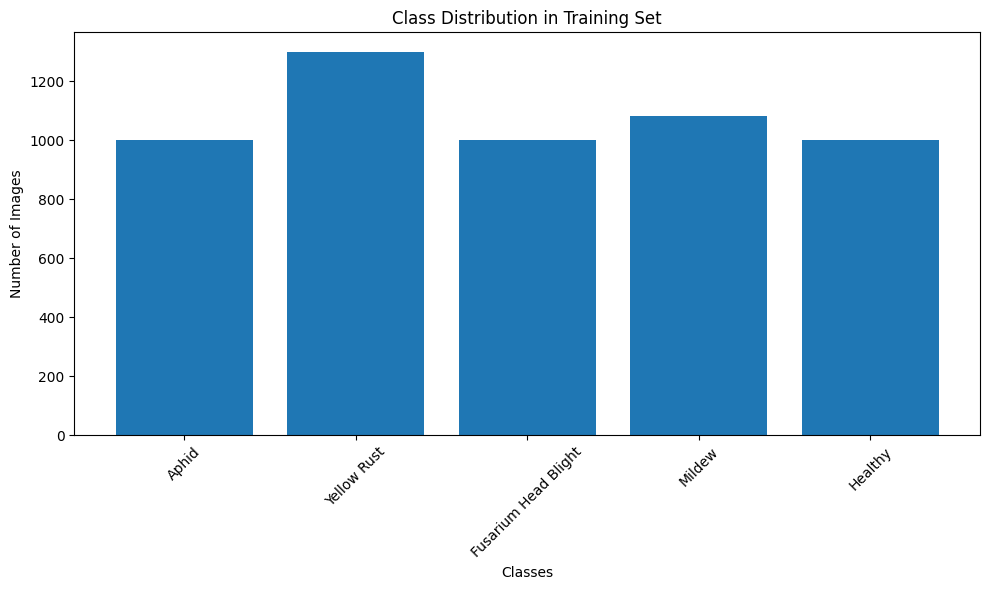

In [12]:
# Create bar plot of training set distribution this helps to check class imbalance
plt.figure(figsize=(10, 6))
class_counts = [len(os.listdir(os.path.join(train_path, cls))) for cls in class_mappings['train']]
plt.bar(class_mappings['train'], class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **4.** Image Properties Analysis

In [13]:
# Function to get unique image properties (5 samples)
def get_unique_properties(dataset_path, classes):
    unique_props = set()

    # Loop through each class
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)

        # Get images in the class folder
        for img_name in os.listdir(class_path):
            img = Image.open(os.path.join(class_path, img_name))
            # Create tuple of properties
            props = (class_name, img.size, img.format, img.mode)
            unique_props.add(props)

            # Break if we have 5 unique combinations
            if len(unique_props) >= 5:
                break
        if len(unique_props) >= 5:
            break

    return list(unique_props)[:5]

In [14]:
# Analyze and display results for each set
print("\nTraining Set:")
train_props = get_unique_properties(train_path, class_mappings['train'])
for class_name, size, format, mode in train_props:
    print(f"{class_name}: Size {size}, Format {format}, Mode {mode}")

print("\nTest Set:")
test_props = get_unique_properties(test_path, class_mappings['test'])
for class_name, size, format, mode in test_props:
    print(f"{class_name}: Size {size}, Format {format}, Mode {mode}")

print("\nValidation Set:")
valid_props = get_unique_properties(valid_path, class_mappings['valid'])
for class_name, size, format, mode in valid_props:
    print(f"{class_name}: Size {size}, Format {format}, Mode {mode}")


Training Set:
Healthy: Size (224, 224), Format JPEG, Mode RGB
Yellow Rust: Size (224, 224), Format JPEG, Mode RGB
Fusarium Head Blight: Size (224, 224), Format JPEG, Mode RGB
Mildew: Size (224, 224), Format JPEG, Mode RGB
Aphid: Size (224, 224), Format JPEG, Mode RGB

Test Set:
aphid_test: Size (224, 224), Format JPEG, Mode RGB
fusarium_head_blight_test: Size (224, 224), Format JPEG, Mode RGB
healthy_test: Size (224, 224), Format JPEG, Mode RGB
mildew_test: Size (224, 224), Format JPEG, Mode RGB
yellow_rust_test: Size (224, 224), Format JPEG, Mode RGB

Validation Set:
mildew_valid: Size (224, 224), Format JPEG, Mode RGB
healthy_valid: Size (224, 224), Format JPEG, Mode RGB
aphid_valid: Size (224, 224), Format JPEG, Mode RGB
fusarium_head_blight_valid: Size (224, 224), Format JPEG, Mode RGB
yellow_rust_valid: Size (224, 224), Format JPEG, Mode RGB


In [15]:
def analyze_dataset(base_path, class_mappings):
    print("Initial Data Analysis:")
    print("-" * 50)

    for class_name in class_mappings['train']:
        class_path = os.path.join(base_path, class_name)
        images = os.listdir(class_path)

        print(f"\n{class_name}:")
        print(f"Total images: {len(images)}")

        # Check image properties
        formats = set()
        modes = set()
        sizes = set()
        corrupted = 0

        for img_name in images:
            try:
                img_path = os.path.join(class_path, img_name)
                with Image.open(img_path) as img:
                    formats.add(img.format)
                    modes.add(img.mode)
                    sizes.add(img.size)
            except:
                corrupted += 1

        print(f"Formats found: {formats}")
        print(f"Color modes: {modes}")
        print(f"Image sizes: {sizes}")
        print(f"Corrupted images: {corrupted}")

## Data Cleaning & Initial Image Preprocessing

##### Training Data Analysis observation
1. **Class** **imbalance** **in** **training** **set** **:** Yellow Rust (1301): most represented
Fusarium Head Blight (611):severely underrepresented
Others (Mildew, Healthy, Aphid): relatively balanced (~900-1000)
2. **Image** **format** **inconsistencies** **:** Mix of JPEG and PNG formats, Multiple image sizes observed, Most images are RGB, others are RGBA rtc
3.  **Quality** **Concerns** **:** Text overlays on some image, Varying backgrounds, Different angles and zoom levels, Some images appear darker/lighter than others
##### Data cleaning and preprocessing pipeline includes:
- Image standardization (size: 224x224)
- Format conversion to RGB
- Corruption removal
- Class balancing through augmentation
  

#### **1**. Handling corrupted Images(Train dataset)

In [16]:
# Check and remove images that can't be opened or are corrupted
def remove_corrupted_images(class_path):
    corrupted = []
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()
                #load as array to catch more issues
                img_array = np.array(img)
        except:
            corrupted.append(img_path)
            os.remove(img_path)
    return corrupted

##### **2**. Finding and removing Duplicates(Train dataset)

In [17]:
#Remove duplicate images using hash comparison
def remove_duplicate_images(class_path):
    hash_dict = {}
    duplicates = []

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                # Calculate image hash
                img_hash = hashlib.md5(np.array(img).tobytes()).hexdigest()

                if img_hash in hash_dict:
                    duplicates.append(img_path)
                    os.remove(img_path)
                else:
                    hash_dict[img_hash] = img_path
        except:
            continue
    return duplicates

##### **3**. Image quality Standardization(train dataset)

In [18]:
#Standardize image format and size
def standardize_image(img, target_size=(224, 224)):
    # Convert to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize
    img = img.resize(target_size)

    return img

#### **4**. Cleaning pipeline (Train dataset)




In [19]:
    """
    This function is pipeline to execute cleaned and preprocessed training images:
    1. Remove corrupted images
    2. Convert to standard format
    3.Resize to standard size
    """
def clean_training_data():
  for class_name in class_mappings['train']:
        print(f"\nProcessing {class_name}")
        class_path = os.path.join(train_path, class_name)
        removed = 0

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                # Open and process image
                img = Image.open(img_path)

                # Convert to RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Resize to standard size
                img = img.resize((224, 224))

                # Save processed image
                img.save(img_path, 'JPEG')

            except Exception as e:
                print(f"Removing corrupted image: {img_name}")
                os.remove(img_path)
                removed += 1

        print(f"Removed {removed} corrupted images")
        print(f"Final count: {len(os.listdir(class_path))} images")
# Run cleaning
clean_training_data()


Processing Aphid
Removed 0 corrupted images
Final count: 1000 images

Processing Yellow Rust
Removed 0 corrupted images
Final count: 1301 images

Processing Fusarium Head Blight
Removed 0 corrupted images
Final count: 1000 images

Processing Mildew
Removed 0 corrupted images
Final count: 1081 images

Processing Healthy
Removed 0 corrupted images
Final count: 1000 images


In [20]:
#verify our cleaned images
for class_name in class_mappings['train']:
    class_path = os.path.join(train_path, class_name)
    count = len(os.listdir(class_path))
    print(f"{class_name}: {count} images")

Aphid: 1000 images
Yellow Rust: 1301 images
Fusarium Head Blight: 1000 images
Mildew: 1081 images
Healthy: 1000 images


#### 5. Balancing Training Data

###### a. Balance dataset through augmentation
        Augment each class to reach atleast 1000 images.
        train_path: Path to training data
        class_mappings: Dictionary of class names




In [21]:
# Based on our cleaned data the distribution is highly imbalanced:
# Yellow Rust: 1301 (Majority class)
# Mildew: 1081
# Healthy: 1000
# Aphid: 903
# Fusarium Head Blight: 611 (Minority class)
# Data Balancing through Augmentation, recommendation of minimum 1000 images per class

def balance_dataset(train_path, class_mappings, target_count=1000):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    for class_name in class_mappings['train']:
        class_path = os.path.join(train_path, class_name)
        current_count = len(os.listdir(class_path))

        if current_count < target_count:
            needed = target_count - current_count
            print(f"Augmenting {class_name} with {needed} images")

            files = os.listdir(class_path)
            for i in range(needed):
                img_path = os.path.join(class_path, random.choice(files))
                img = np.array(Image.open(img_path))
                img = img.reshape((1,) + img.shape)

                aug_img = next(datagen.flow(img, batch_size=1))[0].astype(np.uint8)
                Image.fromarray(aug_img).save(
                    os.path.join(class_path, f'aug_{i}.jpg'),
                    'JPEG',
                    quality=95
                )

# Balance the dataset
balance_dataset(train_path, class_mappings)

#### 6. cleaning and preprocessing validation set
- Similar cleaning and standardization as trainset
- No augmentation to maintain evaluation integrity


In [22]:
def clean_validation_data():
    
    for class_name in class_mappings['valid']:
        print(f"\nProcessing {class_name}")
        class_path = os.path.join(valid_path, class_name)
        removed = 0
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                # Open and process image
                img = Image.open(img_path)
                
                # Convert to RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Resize to standard size
                img = img.resize((224, 224))
                
                # Save processed image
                img.save(img_path, 'JPEG')
                
            except:
                print(f"Removing corrupted image: {img_name}")
                os.remove(img_path)
                removed += 1
        
        print(f"Removed {removed} corrupted images")
        print(f"Final count: {len(os.listdir(class_path))} images")
clean_validation_data()


Processing aphid_valid
Removed 0 corrupted images
Final count: 20 images

Processing yellow_rust_valid
Removed 0 corrupted images
Final count: 20 images

Processing fusarium_head_blight_valid
Removed 0 corrupted images
Final count: 20 images

Processing mildew_valid
Removed 0 corrupted images
Final count: 20 images

Processing healthy_valid
Removed 0 corrupted images
Final count: 20 images


#### **7**. Clean and preprocess test data
- Similar cleaning and standardization
- No augmentation to maintain evaluation integrity


In [23]:
def clean_test_data():
    print("\nProcessing test data")
    
    for class_name in class_mappings['test']:
        print(f"\nProcessing {class_name}")
        class_path = os.path.join(test_path, class_name)
        removed = 0
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                # Open and process image
                img = Image.open(img_path)
                
                # Convert to RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Resize to standard size
                img = img.resize((224, 224))
                
                # Save processed image
                img.save(img_path, 'JPEG')
                
            except:
                print(f"Removing corrupted image: {img_name}")
                os.remove(img_path)
                removed += 1
        
        print(f"Removed {removed} corrupted images")
        print(f"Final count: {len(os.listdir(class_path))} images")
clean_test_data()


Processing test data

Processing aphid_test
Removed 0 corrupted images
Final count: 50 images

Processing yellow_rust_test
Removed 0 corrupted images
Final count: 50 images

Processing fusarium_head_blight_test
Removed 0 corrupted images
Final count: 50 images

Processing mildew_test
Removed 0 corrupted images
Final count: 50 images

Processing healthy_test
Removed 0 corrupted images
Final count: 50 images


##  Inspection After Cleaning, Balancing and Augmentation

### 1. Image count and class distribution

In [24]:
print("Class train distribution")
for class_name in class_mappings['train']:
    total = len(os.listdir(os.path.join(train_path, class_name)))
    print(f"{class_name}: {total} images")

Class train distribution
Aphid: 1000 images
Yellow Rust: 1301 images
Fusarium Head Blight: 1000 images
Mildew: 1081 images
Healthy: 1000 images


### 2.  Final train image properties

In [25]:
def view_final_properties():
    print("\nImage properties")

    for class_name in class_mappings['train']:
        print(f"\n{class_name}:")
        class_path = os.path.join(train_path, class_name)

        # Get random sample image
        sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
        img = Image.open(sample_img_path)

        print(f"Size: {img.size}")
        print(f"Mode: {img.mode}")
        print(f"Format: {img.format}")

# View properties
view_final_properties()


Image properties

Aphid:
Size: (224, 224)
Mode: RGB
Format: JPEG

Yellow Rust:
Size: (224, 224)
Mode: RGB
Format: JPEG

Fusarium Head Blight:
Size: (224, 224)
Mode: RGB
Format: JPEG

Mildew:
Size: (224, 224)
Mode: RGB
Format: JPEG

Healthy:
Size: (224, 224)
Mode: RGB
Format: JPEG


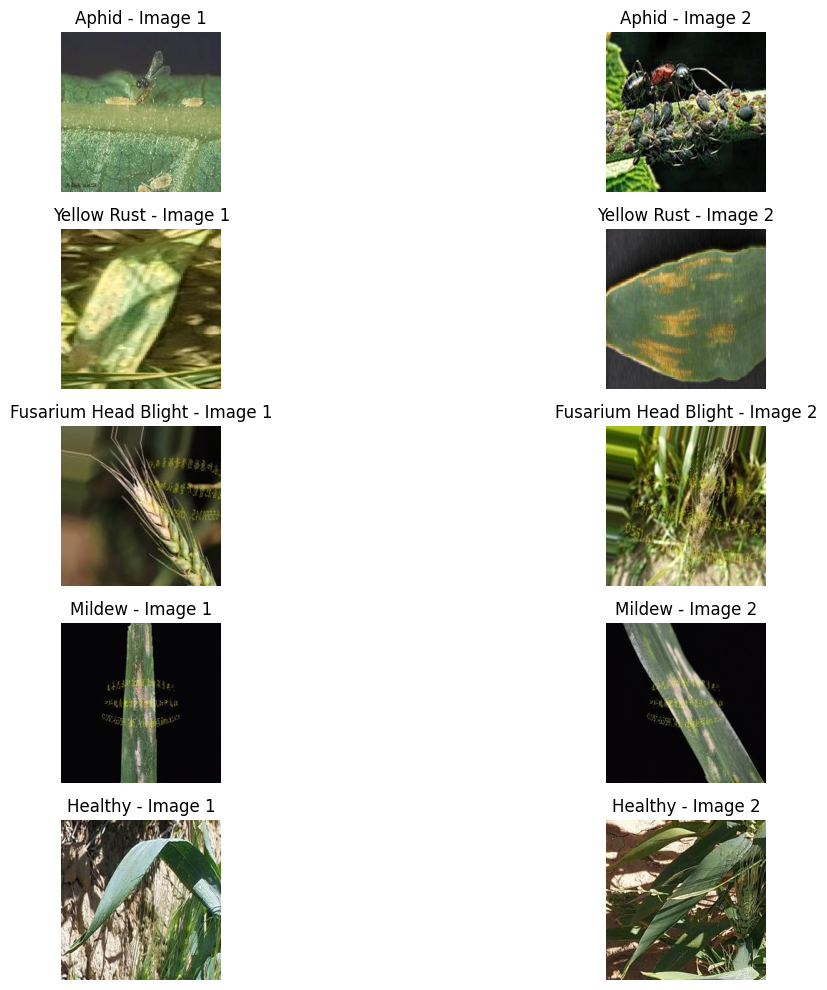

In [26]:
# Display random images per class
def view_sample_images():
   plt.figure(figsize=(15, 10))

   for idx, class_name in enumerate(class_mappings['train']):
       class_path = os.path.join(train_path, class_name)
       images = os.listdir(class_path)

       # Select two random images
       sample_images = random.sample(images, 2)

       # Display first image
       plt.subplot(5, 2, 2*idx + 1)
       img1 = Image.open(os.path.join(class_path, sample_images[0]))
       plt.imshow(img1)
       plt.title(f"{class_name} - Image 1")
       plt.axis('off')

       # Display second image
       plt.subplot(5, 2, 2*idx + 2)
       img2 = Image.open(os.path.join(class_path, sample_images[1]))
       plt.imshow(img2)
       plt.title(f"{class_name} - Image 2")
       plt.axis('off')

   plt.tight_layout()
   plt.show()

# View sample images
view_sample_images()

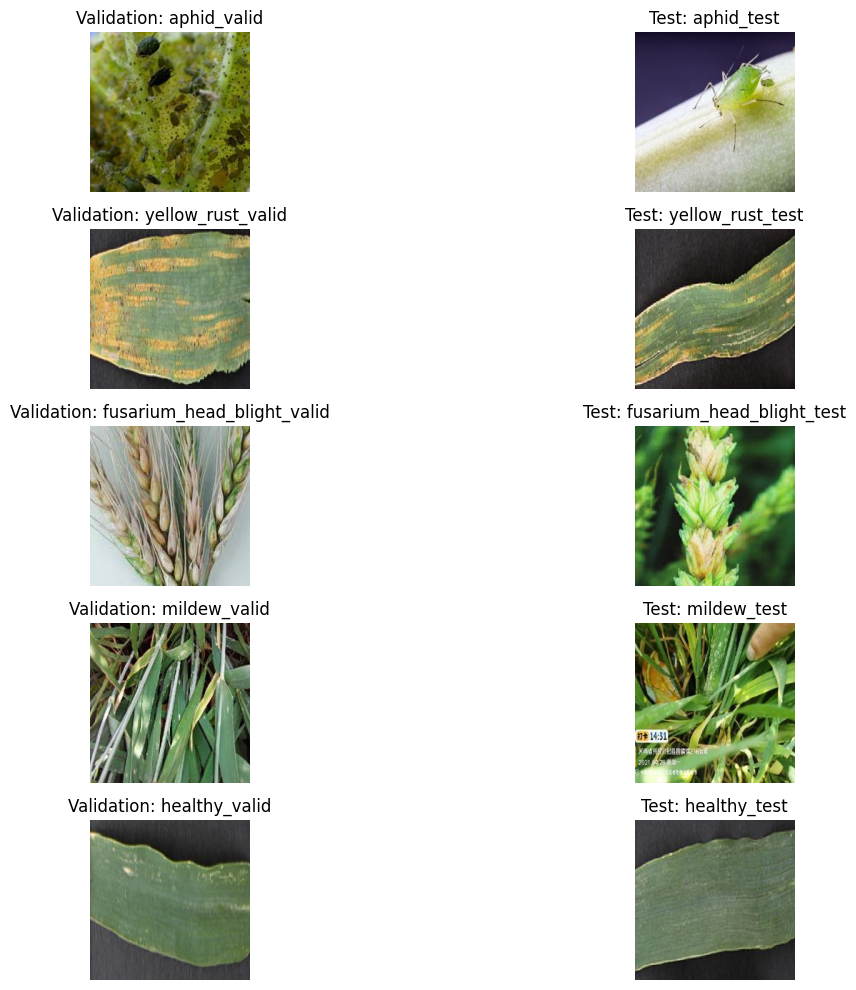

In [27]:
# View sample images after processing (validation and test datasets)
def view_processed_images():
    plt.figure(figsize=(15, 10))
    
    # Show validation samples
    for idx, class_name in enumerate(class_mappings['valid']):
        class_path = os.path.join(valid_path, class_name)
        img_name = random.choice(os.listdir(class_path))
        img = Image.open(os.path.join(class_path, img_name))
        
        plt.subplot(5, 2, 2*idx + 1)
        plt.imshow(img)
        plt.title(f"Validation: {class_name}")
        plt.axis('off')
        
        # Show test samples
        test_class = class_mappings['test'][idx]
        class_path = os.path.join(test_path, test_class)
        img_name = random.choice(os.listdir(class_path))
        img = Image.open(os.path.join(class_path, img_name))
        
        plt.subplot(5, 2, 2*idx + 2)
        plt.imshow(img)
        plt.title(f"Test: {test_class}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
view_processed_images()

## Model Development


### Set up Data generators
###### Three separate generators for:
- Training (with augmentation)
- Validation (no augmentation)
- Test (no augmentation)

Image size: 160x160
Batch size: 32

In [28]:
#First, I'm setting up my data generators with augmentation to help work with overfitting.
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

# Using simple preprocessing for validation and test
valid_test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    classes=class_mappings['train'],
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    classes=class_mappings['valid'],
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    classes=class_mappings['test'],
    class_mode='categorical',
    shuffle=False
)

Found 5382 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [29]:
 # Create callbacks for model training:
 #    - Early stopping to prevent overfitting
 #    - Model checkpoint to save best model
 #    - Learning rate reduction when model plateaus 
def create_callbacks(model_name):
    callbacks = [
        # Stop training when validation loss stops improving
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        
        # Reduce learning rate when model plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7
        ),
        
        # Save best model during training
        ModelCheckpoint(
            f'{model_name}_best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
    
    return callbacks

### Model Architecture
We'll implement and compare 3 different architectures:

1. EfficientNetB0 - Efficient and accurate, good for moderate dataset sizes
2. MobileNetV2 - Lighter and faster, good for mobile deployment
3. ResNet50V2 - Deep and robust, good for complex feature extraction

1. EfficientNetBO Model

In [30]:
# EfficientNetB0 Architecture
#     - Pre-trained on ImageNet
#     - Limited number of trainable layers
#     - Custom classification head
def create_efficient_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze initial layers
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

2. MobileNetV2 model

In [31]:
from tensorflow.keras.layers import BatchNormalization

In [32]:
# MobileNetV2 Architecture
    # - Pre-trained on ImageNet
    # - Optimized for mobile deployment
    # - Custom classification head

def create_mobilenet_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze initial layers
    for layer in base_model.layers[:-15]:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

3. ResNet50V2 Model

In [33]:
from tensorflow.keras.applications import  ResNet50V2

In [34]:
# ResNet50V2 Architecture
    # - Pre-trained on ImageNet
    # - Deep architecture with residual connections
    # - Custom classification head

def create_resnet_model():
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze initial layers
    for layer in base_model.layers[:-15]:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

### Training and Configuration of Models

In [35]:
# Compiles and trains the model
def compile_and_train_model(model, model_name, train_generator, valid_generator):
    # Use Adam optimizer
    optimizer = Adam(
        learning_rate=1e-4,
        weight_decay=1e-6
    )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Create callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=30,
        callbacks=callbacks,
        verbose=1  # Show progress bar
    )
    
    return history

   Training EfficientNetB0

In [36]:
# Create and train EfficientNetB0 model
efficient_model = create_efficient_model()
efficient_history = compile_and_train_model(
    efficient_model,
    'efficientnet',
    train_generator,
    valid_generator
)   

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.5296 - loss: 1.3473 - val_accuracy: 0.6400 - val_loss: 1.5290 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.8269 - loss: 0.4895 - val_accuracy: 0.7200 - val_loss: 2.0040 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.8765 - loss: 0.3481 - val_accuracy: 0.7200 - val_loss: 2.1161 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8913 - loss: 0.3030 - val_accuracy: 0.7600 - val_loss: 2.2361 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9057 - loss: 0.2631 - val_accuracy: 0.7600 - val_loss: 2.4087 - learning_rate: 5.0000e-05
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9146 - loss: 0.2468 - val_accuracy: 0.7700 - val_loss: 2.5104 - learning_rate: 5.0000e-05


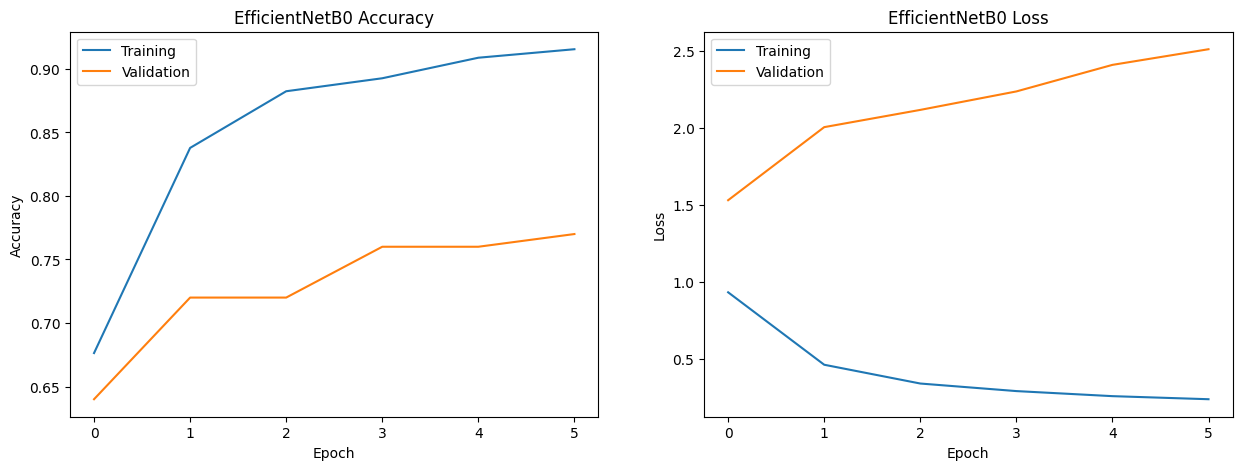

In [37]:
# Visualize EfficientNetB0 results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(efficient_history.history['accuracy'], label='Training')
plt.plot(efficient_history.history['val_accuracy'], label='Validation')
plt.title('EfficientNetB0 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficient_history.history['loss'], label='Training')
plt.plot(efficient_history.history['val_loss'], label='Validation')
plt.title('EfficientNetB0 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training MobileNet

In [38]:
mobile_model = create_mobilenet_model()
mobile_history = compile_and_train_model(
    mobile_model,
    'mobilenet',
    train_generator,
    valid_generator
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.4359 - loss: 1.6649 - val_accuracy: 0.3800 - val_loss: 1.5003 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.6296 - loss: 1.0196 - val_accuracy: 0.4400 - val_loss: 1.6253 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.6558 - loss: 0.9422 - val_accuracy: 0.4400 - val_loss: 1.9025 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.6943 - loss: 0.8167 - val_accuracy: 0.5400 - val_loss: 2.1816 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.7191 - loss: 0.7558 - val_accuracy: 0.4900 - val_loss: 2.1791 - learning_rate: 5.0000e-05
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.7178 - loss: 0.7517 - val_accuracy: 0.5400 - val_loss: 2.0406 - learning_rate: 5.0000e-05


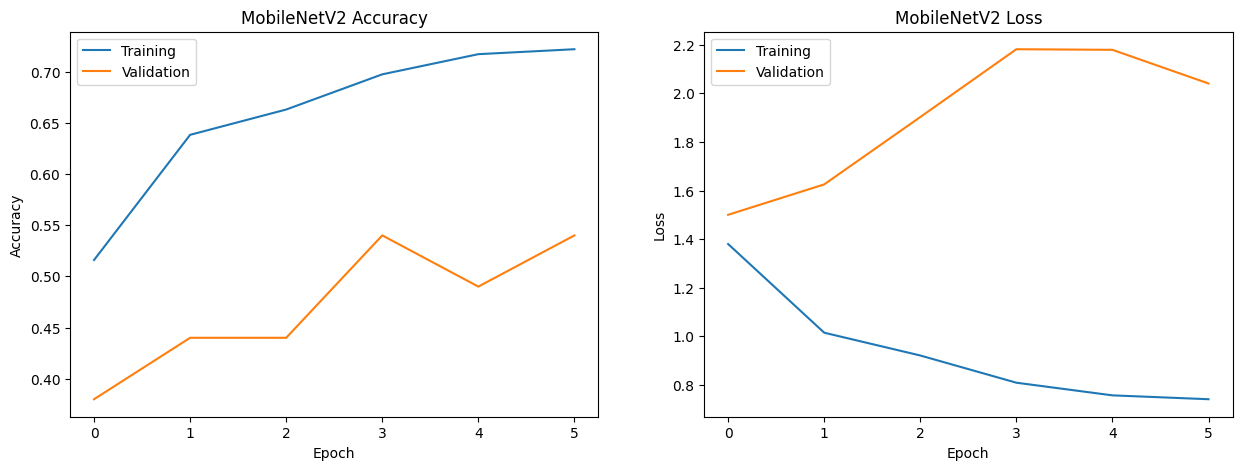

In [39]:
# Visualize MobileNetV2 results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(mobile_history.history['accuracy'], label='Training')
plt.plot(mobile_history.history['val_accuracy'], label='Validation')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobile_history.history['loss'], label='Training')
plt.plot(mobile_history.history['val_loss'], label='Validation')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

ResNetModel

In [40]:
# Create and train ResNet model with early stopping and learning rate reduction
resnet_model = create_resnet_model()
resnet_history = compile_and_train_model(
    resnet_model,
    'resnet',
    train_generator,
    valid_generator
)


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1201s 7s/step - accuracy: 0.4394 - loss: 1.4011 - val_accuracy: 0.3900 - val_loss: 1.4648 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1170s 7s/step - accuracy: 0.6183 - loss: 0.9994 - val_accuracy: 0.4800 - val_loss: 1.3811 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1177s 7s/step - accuracy: 0.6629 - loss: 0.9034 - val_accuracy: 0.5600 - val_loss: 1.4134 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1305s 8s/step - accuracy: 0.6874 - loss: 0.8399 - val_accuracy: 0.5000 - val_loss: 1.6707 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1126s 7s/step - accuracy: 0.7024 - loss: 0.7943 - val_accuracy: 0.5600 - val_loss: 1.4368 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1155s 7s/step - accuracy: 0.7310 - loss: 0.7353 - val_accuracy: 0.5700 - val_loss: 1.4244 - learning_rate: 5.0000e-05
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1170s 7s/ste

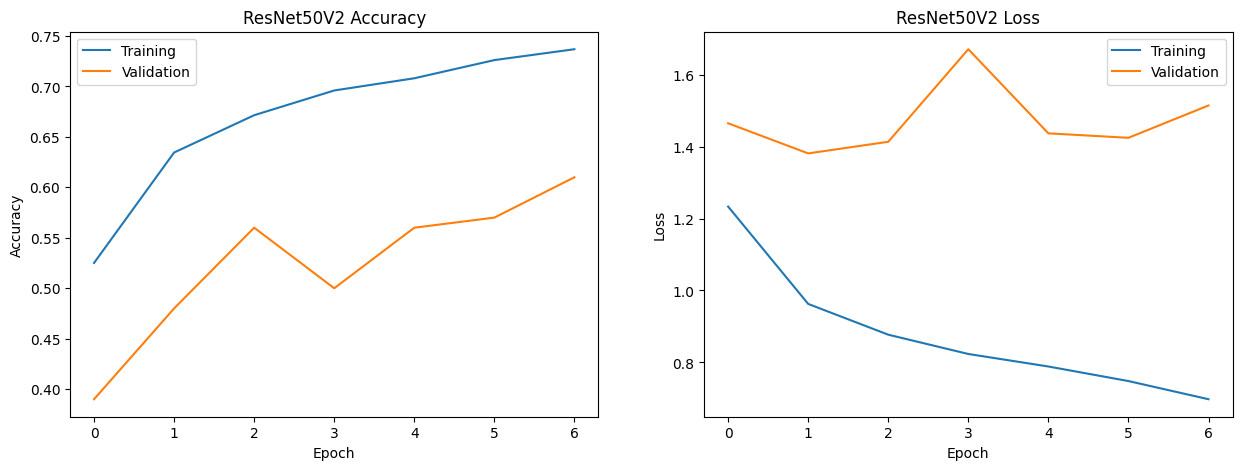

In [41]:
# Visualize ResNet50V2 results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Training')
plt.plot(resnet_history.history['val_accuracy'], label='Validation')
plt.title('ResNet50V2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Training')
plt.plot(resnet_history.history['val_loss'], label='Validation')
plt.title('ResNet50V2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

    Testing and evaluating efficientNet Model

In [45]:
best_model = efficient_model  # Since we used restore_best_weights=True in callbacks

In [46]:
# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7686 - loss: 0.8093

Test Accuracy: 0.6680
Test Loss: 1.5456


In [47]:
# Generate predictions and confusion matrix
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [49]:
from sklearn.metrics import confusion_matrix

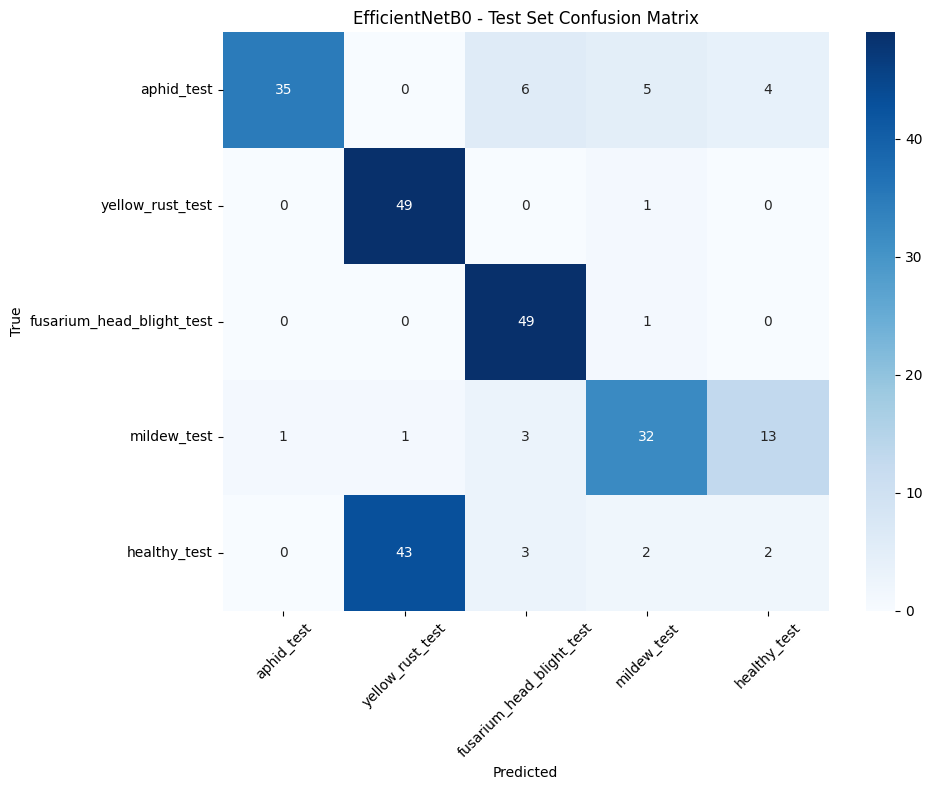

In [50]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mappings['test'],
            yticklabels=class_mappings['test'])
plt.title('EfficientNetB0 - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
best_model.save('best_efficientnet_final.keras')
print("Model saved")

Model saved
